## Assignment 2 
### \<Lipin Guo> \<a1865281>

In [3]:
# Libraries for reading data
import numpy as np
import pandas as pd 
from tqdm import tqdm
import glob
import json
from google.colab import drive
drive.mount('/content/drive')

# Libraries for pre-processing
import re
import nltk
import string
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Libraries for information retrival
# !pip install spacy
import spacy
# Load English tokenizer, tagger, parser and NER
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# !python -m spacy download en_core_web_md
nlp_md = spacy.load("en_core_web_md")
from spacy.lang.en import English
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Libraries for data analysis
import matplotlib.pyplot as plt
# # !pip install tabulate
# from tabulate import tabulate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 1. Reading dataset and pre-processing

#### 1.1 Summary
Our dataset is COVID-19 Open Research Dataset (CORD-19). According to Kaggle, the dataset contains "1,000,000 scholarly articles,  including over 400,000 with full text" and topics are about "COVID-19, SARS-CoV-2, and related coronaviruses" [1]. 

First, we manully download dataset from Kaggle and reading data. For full text, there are two formats: PDF and PMC. In our experiment, we selected PMC as the PDF data has more missing information especially missing some cord_uid. The whole dataset has the size of around 20 Gigabytesis so we need to use a random sample. Our **sample size is 10,000 articles**, which is 1% of orginal data size. (Section 1.2 Reading dataset) 

data columns:

*   docid: using cord_uid
*   doi
*   authors
*   title
*   journal
*   body

Then, we pre-process data including **removing stopwords and Lemmalization**(Section 1.3 Data Pre-processing). **Removing stopwords** help to concentrate on important information. **Lemmalization** return root words. **removing stopwords and Lemmalization** will not influence the major semantic of sentences. We would like to keep data in sentence level to analyze semantics, that's why we does not remove puncuation. In order to have better named entity recognition, we keep capitalization as captical words have special meaning and can be used to identify name, organization and place.

Finally, we saved the data into data_v2_clean. 

P.S. Save each version of data into csv format to avoid repeating operation.

#### 1.2 Reading dataset

In [ ]:
# ref: https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering
# First, manually download data from Kaggle
# Second, loading data from local directory
metadata_path = './archive/metadata.csv'
meta_df = pd.read_csv(metadata_path,low_memory=False)
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
# ref: https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering
# fetching PMC JSON file
pmc_json = ! ls ./archive/document_parses/pmc_json
print(type(pmc_json))
print("The size of PMC JSON file is ", len(pmc_json))
pmc_json = ["./archive/document_parses/pmc_json/" + s for s in pmc_json]
pmc_json[:5]

<class 'IPython.utils.text.SList'>
The size of PMC JSON file is  315742


['./archive/document_parses/pmc_json/PMC1054884.xml.json',
 './archive/document_parses/pmc_json/PMC1065028.xml.json',
 './archive/document_parses/pmc_json/PMC1065064.xml.json',
 './archive/document_parses/pmc_json/PMC1065120.xml.json',
 './archive/document_parses/pmc_json/PMC1065257.xml.json']

In [ ]:
# ref: https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering
# Reader class for JSON file
class Reader:
    def __init__(self, file_path):
        with open(file_path) as f:
            content = json.load(f)
            self.paper_id = content['paper_id']
            self.title = content['metadata']['title']
            self.body_text = []
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])   
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.title[:200]}... {self.body_text[:200]}...'
    
first_row = Reader(pmc_json[1])
print(first_row)

PMC1065028: Why can't I visit? The ethics of visitation restrictions – lessons learned from SARS... The sudden emergence of severe acute respiratory syndrome (SARS) in April 2003 caused much concern and reaction. Refereed medical journals ever since have been rife with articles about SARS. The event...


In [ ]:
# ref: https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering
# Data Sampling
def data_sampling(sample_size):

    # Using random seed to sample data  
    import random
    random.seed(0)
    pmc_sample = random.sample(pmc_json, sample_size)

    # Data sampling
    article_df = {
        'docid': [],
        'doi': [], 
        'authors': [], 
        'title': [], 
        'journal': [],
        'body': []}

    for idx, entry in tqdm(enumerate(pmc_sample), total = len(pmc_sample)):
        try:
            content = Reader(entry)
        except Exception as e:
            continue  # invalid paper format, skip
        
        # get metadata information
        meta_data = meta_df.loc[meta_df['pmcid'] == content.paper_id]
        # no metadata, skip this paper
        if len(meta_data) == 0:
            continue
        if len(content.body_text) == 0:
            continue
            
        
        article_df['body'].append(content.body_text)
        article_df['title'].append(content.title)
        article_df['docid'].append(meta_data['cord_uid'].values[0])
        article_df['authors'].append(meta_data['authors'].values[0])
        
        # add the journal information
        article_df['journal'].append(meta_data['journal'].values[0])
        
        # add doi
        article_df['doi'].append(meta_data['doi'].values[0])
    covid_df = pd.DataFrame(article_df, columns=['docid','doi', 'authors', 'title', 'journal','body'])
    return covid_df

In [ ]:
# Data downsampling
sample_size = 10000
covid_df = data_sampling(sample_size)
# Save dataset as csv
covid_df.to_csv("covid_articles.csv",index=False)

100%|█████████████████████████████████████| 10000/10000 [06:04<00:00, 27.46it/s]


#### 1.3 Data Pre-processing

In [ ]:
# Overview of sampled data
# data_v1: original data
data_v1 = pd.read_csv("/content/drive/My Drive/covid_articles.csv", index_col=False)
data_v1.head()

,docid,doi,authors,title,journal,body
0,ynh8eo6x,10.1007/s11125-021-09564-8,"Amin, Nyna; Mahabeer, Pryah",Curriculum tinkering in situations of crises a...,Prospects (Paris),"In this section, we provide an overview of Sou..."
1,g0bgp3t7,10.3389/fimmu.2021.754642,"Coleman, Celeste; Doyle-Meyers, Lara A.; Russe...",Similarities and Differences in the Acute-Phas...,Front Immunol,The rapid emergence and dissemination of sever...
2,x1r99rlm,10.3382/ps/pev336,"Yokhana, J. S.; Parkinson, G.; Frankel, T. L.",Effect of insoluble fiber supplementation appl...,Poult Sci,Growth and development in layer pullets during...
3,m5pwtv7d,10.1007/978-3-030-51761-8_5,"Alonayq, Abdulmohsen",Narrating Arabic Translation Online: Another P...,When Translation Goes Digital,The translation sector has seen an increase in...
4,ztzsj45b,10.3390/cells11030575,"Suzuki, Hiroyuki; Kaneko, Mika K.; Kato, Yukinari",Roles of Podoplanin in Malignant Progression o...,Cells,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...


In [ ]:
# Step 1: Checking data type
data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   docid    10000 non-null  object
 1   doi      9973 non-null   object
 2   authors  9849 non-null   object
 3   title    10000 non-null  object
 4   journal  9946 non-null   object
 5   body     10000 non-null  object
dtypes: object(6)
memory usage: 468.9+ KB


In [ ]:
# Step 2: Handling missing value
def handling_missing_value(data):
    # checking missing value
    print("Missing value in original data data_v1\n", data.isnull().sum())
    # Handling missing value
    data['doi'] = data['doi'].fillna('No_doi')
    data['authors'] = data['authors'].fillna('No_authors')
    data['journal'] = data['journal'].fillna('No_journal')
    # checking missing value after handling missing value
    print("_"*20)
    print("Missing value in new data data_v2\n", data.isnull().sum())
    return data

print("data_v2: handling missing value")
data_v2 = handling_missing_value(data_v1)

data_v2: handling missing value
Missing value in original data data_v1
 docid        0
doi         27
authors    151
title        0
journal     54
body         0
dtype: int64
____________________
Missing value in new data data_v2
 docid      0
doi        0
authors    0
title      0
journal    0
body       0
dtype: int64


In [ ]:
# Step 3: Data pre-processing
stop_words = stopwords.words('english')
stop_words.extend(["This", "The", "the"])
def pre_process(data):

    # regular expression to match text patterns
    s = " \[(?=.*\d).*?\]" 

    # Removing stopwords + Lemmalization
    # Stop words are common words that are typically removed from text data before analysis.
    # Lemmatization is the process of reducing a word to its base form, known as its lemma.   
    lemmatizer = WordNetLemmatizer()
    result = [" ".join([lemmatizer.lemmatize(word) for word in re.sub(s, "", text).split() if word not in stop_words]) for text in data]

    return result

In [ ]:
# data_v2['clean'] includes data_v2['body'] pre-processing
data_v2['clean'] = pre_process(data_v2['body'])
# Save dataset as csv
data_v2.to_csv("/content/drive/My Drive/covid_data_v2.csv",index=False)

In [4]:
# data_v2_clean: data_v2 + pre-processing
data_v2_clean = pd.read_csv("/content/drive/My Drive/covid_data_v2.csv", index_col=False)
data_v2_clean.head()

,docid,doi,authors,title,journal,body,clean
0,ynh8eo6x,10.1007/s11125-021-09564-8,"Amin, Nyna; Mahabeer, Pryah",Curriculum tinkering in situations of crises a...,Prospects (Paris),"In this section, we provide an overview of Sou...","In section, provide overview South Africa’s de..."
1,g0bgp3t7,10.3389/fimmu.2021.754642,"Coleman, Celeste; Doyle-Meyers, Lara A.; Russe...",Similarities and Differences in the Acute-Phas...,Front Immunol,The rapid emergence and dissemination of sever...,rapid emergence dissemination severe acute res...
2,x1r99rlm,10.3382/ps/pev336,"Yokhana, J. S.; Parkinson, G.; Frankel, T. L.",Effect of insoluble fiber supplementation appl...,Poult Sci,Growth and development in layer pullets during...,Growth development layer pullet rearing early ...
3,m5pwtv7d,10.1007/978-3-030-51761-8_5,"Alonayq, Abdulmohsen",Narrating Arabic Translation Online: Another P...,When Translation Goes Digital,The translation sector has seen an increase in...,translation sector seen increase volunteer tra...
4,ztzsj45b,10.3390/cells11030575,"Suzuki, Hiroyuki; Kaneko, Mika K.; Kato, Yukinari",Roles of Podoplanin in Malignant Progression o...,Cells,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...,Podoplanin (PDPN)/T1α/E11 antigen/PA2.26 antig...


### 2. Named Entity Recognition and Knowledge Base

#### 2.1 Summary
For NER, we use **Spacy** by **get_ner function** to recognize named entitites as it has better performance compared to NLTK. Our NER (called **entities**) is a dictionary using "docid" as keys, while a list of dictionaries (named entities and named entities labels as key) are associated items related to a specail key(Section 2.2 NER).

For Knowledge Base, we create a dictionary called self.kb in Knowledge Base class. The keys are canonical names, such as "COVID-19", and values for each key are {"relation": xx, "objects"(associated name): [xx,xx]}. We would like to use KB "relation" to help text matching in sentence level and find a better answer according to relation in Section 4 Test Matching Utility. Use KB "object" in case that we miss some associated named entities, for example, "covid", "COVD-19". 

It can be more complex such as build a knowledge base by anaylzeing each sentence and create dictionary/DataFrame for each sentence in all sample articles. However, it can be time consuming which is not suitable for this small project. But it may be an experiment in the feature. Also, as we removing stopwords, which will affect us to construct relationship of each sentence.

In our experiment, manualy build knowledge base has correct relationship between subjects and objects compared to auto build knowledge base, in which using tagging to analysis each word in a sentence. (Section 2.3 Knowledge Base)

P.S. Save NER dictionary to json file as it is very large and needs massive computing time. **In order to handle a small knowledge base and entities, we only use the first 30 articles for experiments in the following part**.

#### 2.2 NER

In [ ]:
from spacy import displacy
class named_entity_recognition:
    def __init__(self):
        self.NER = {}
    
    def example(self, doc):
        # Process whole document
        text = nlp(doc)
        displacy.render(text, style="ent",jupyter=True)
        return None
    
    def get_ner(self, data):
        """
        The function is about name entity recognition.
        Input:
        data-> whole data includes "docid" and "clean"
        Output: dictionary

        """

        for i in range(data.shape[0]):
            # Get document id
            key = data['docid'][i]
            # Process whole documents
            text = nlp(str(data['clean'][i]))
            # Find named entities, labels
            for ent in text.ents: 
                # Check named entities existing or not
                if key not in self.NER.keys():
                    self.NER[key] = [{"text":ent.text.strip(),"label":ent.label_}]
                else:
                    # Avoid duplicate named entities
                    if [ent.text.strip(), ent.label_] not in self.NER[key]:
                        self.NER[key].append({"text":ent.text.strip(),"label":ent.label_})    
        return self.NER

In [ ]:
ner = named_entity_recognition()
# visualization of part of named entities from an article
ner.example(data_v2_clean['clean'][0][:400])

In [ ]:
# ner_dic includes document id and NER
ner_dic = ner.get_ner(data_v2_clean)

In [5]:
def write_json(dictionary, filename):
    # save dic as a string
    string =  json.dumps(dictionary)
    
    # save string to json file
    with open(filename, 'w') as f1:
        f1.write(string)
  
def read_json(filename):
    # read string from json file
    with open(filename, 'r') as f2:
        content = f2.read()

    # get the dictionary from json file
    output = json.loads(content)
    
    return output

In [ ]:
# As ner_dic is very large, we decided to save the ner_dic into json format and store in google drive
write_json(ner_dic, '/content/drive/My Drive/ner.json')

In [6]:
# Get ner_dic in json format from google drive and rename as entities
entities = read_json('/content/drive/My Drive/ner.json')

In [ ]:
# The entities dictionary is too big to overview, we just simply print the length of it.
print("The length of entities is: ",len(entities))
print("A example of entities is \n", entities['ynh8eo6x'])

The length of entities is:  9820
A example of entities is 
 [{'text': 'South Africa’s', 'label': 'GPE'}, {'text': '2011', 'label': 'DATE'}, {'text': 'Shrestha', 'label': 'GPE'}, {'text': 'al. 2019', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': 'Taba', 'label': 'GPE'}, {'text': '50 year ago', 'label': 'DATE'}, {'text': '1962', 'label': 'DATE'}, {'text': '33', 'label': 'CARDINAL'}, {'text': 'twenty-first century', 'label': 'DATE'}, {'text': 'World Bank', 'label': 'ORG'}, {'text': 'International Labour Organisation', 'label': 'ORG'}, {'text': 'UNESCO', 'label': 'ORG'}, {'text': 'World Economic Forum', 'label': 'ORG'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': '2017', 'label': 'DATE'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': '55%', 'label': 'PERCENT'}, {'text': '30.4 million', 'label': 'CARDINAL'}, {'text': '25.2%', 'label': 'PERCENT'}, {'text': '13.8 million', 'label': 'CARDINAL'}, {'text': '30.4 mill

In [ ]:
# Manually handling some specail case
entities['ynh8eo6x'][0]['text'] = 'South Africa'
print("A example of entities is \n", entities['ynh8eo6x'])

A example of entities is 
 [{'text': 'South Africa', 'label': 'GPE'}, {'text': '2011', 'label': 'DATE'}, {'text': 'Shrestha', 'label': 'GPE'}, {'text': 'al. 2019', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': 'Taba', 'label': 'GPE'}, {'text': '50 year ago', 'label': 'DATE'}, {'text': '1962', 'label': 'DATE'}, {'text': '33', 'label': 'CARDINAL'}, {'text': 'twenty-first century', 'label': 'DATE'}, {'text': 'World Bank', 'label': 'ORG'}, {'text': 'International Labour Organisation', 'label': 'ORG'}, {'text': 'UNESCO', 'label': 'ORG'}, {'text': 'World Economic Forum', 'label': 'ORG'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': 'South African', 'label': 'NORP'}, {'text': '2017', 'label': 'DATE'}, {'text': 'South Africa', 'label': 'GPE'}, {'text': '55%', 'label': 'PERCENT'}, {'text': '30.4 million', 'label': 'CARDINAL'}, {'text': '25.2%', 'label': 'PERCENT'}, {'text': '13.8 million', 'label': 'CARDINAL'}, {'text': '30.4 million', 'label': 'CARDINAL'}, {'text'

In [7]:
# In order to perform experiment in small dataset
# only get the named entities in first 20 articles
cnt = 0
entities_30 = {}
for k, v in entities.items():
    entities_30[k] = v
    cnt += 1
    if cnt == 30:
      break

print(entities_30.keys())

dict_keys(['ynh8eo6x', 'g0bgp3t7', 'x1r99rlm', 'm5pwtv7d', 'ztzsj45b', 'whchytrr', 'yi870wr8', 'lswvw426', 'l9vye5ci', '1iyz9nn2', 'hm0ovsq4', 'ltgadsp7', '0n0vbax3', '0o4zxngp', 'c2ibxbgo', '7rrwtmw2', '10409mar', 'okihfpp6', 'xtu9r72l', 'jfca5rv6', '9k1fb5bs', 'qk0cyee2', 'ymebxodh', 'h4hxvov8', 'dtyrjfo5', 'daix3d5e', 'yajnzgd5', 'gcc1qjej', 'r9c4odva', 'njrtn2jg'])


#### 2.3 Knowledge Base

In [32]:
# code ref :
# https://www.holisticseo.digital/python-seo/information-extraction/
# https://github.com/vibhavnirmal/Knowledge-Graph-based-QnA/blob/master/kwQnA/_graph.py

class KnowledgeBase:
    def __init__(self, data):
        self.data = data
        self.kb= {}

    def getSentences(self,text):
        nlp = English()
        nlp.add_pipe(nlp.create_pipe('sentencizer'))
        document = nlp(text)
        return [sent.string.strip() for sent in document.sents]

    def appendChunk(self, original, chunk):
        return original + ' ' + chunk

    def isRelationCandidate(self, token):
        # defines a list of dependencies called "deps" 
        # that are commonly associated with relations in a sentence
        deps = ["ROOT", "adj", "attr", "agent", "amod"]
        return any(subs in token.dep_ for subs in deps)

    def isConstructionCandidate(self, token):
        deps = ["compound", "prep", "conj", "mod"]
        return any(subs in token.dep_ for subs in deps)

    def processSubjectObjectPairs(self, tokens):
        sub = ''
        obj = ''
        relation = ''
        subjectConstruction = ''
        objectConstruction = ''
        for token in tokens:
            if "punct" in token.dep_:
                continue
            if self.isRelationCandidate(token):
                relation = self.appendChunk(relation, token.lemma_)
            if self.isConstructionCandidate(token):
                if subjectConstruction:
                    subjectConstruction = self.appendChunk(subjectConstruction, token.text)
                if objectConstruction:
                    objectConstruction = self.appendChunk(objectConstruction, token.text)
            if "subj" in token.dep_:
                sub = self.appendChunk(sub, token.text)
                sub = self.appendChunk(subjectConstruction, sub)
                subjectConstruction = ''
            if "obj" in token.dep_:
                obj = self.appendChunk(obj, token.text)
                obj = self.appendChunk(objectConstruction, obj)
                objectConstruction = ''

        return (sub.strip(), relation.strip(), obj.strip())

    def auto_build_kb(self):
        for i in range(len(self.data)):
            doc = self.data['clean'][i]
            sentences = list(doc.split('.'))
            # print(len(sentences))
            for sentence in sentences:                 
                s = nlp(sentence)
                sub, rel, obj = self.processSubjectObjectPairs(s)
                # set conditions
                if sub not in self.kb.keys() and sub.strip() != "" and rel.strip() != "" and obj.strip() != "":
                    self.kb[sub] = [{"relation":rel, "object": obj}]
                elif sub in self.kb.keys() and sub.strip() != "" and rel.strip() != "" and obj.strip() != "":
                    self.kb[sub].append({"relation":rel, "object": obj})

    def manually_build_kb(self, ent_pairs):
        if ent_pairs['canonical'] != self.kb.keys():
            self.kb[ent_pairs['canonical']] = [{"relation":ent_pairs['relation'], "object": ent_pairs['associated']}]
        else:
            self.kb[ent_pairs['canonical']].append({"relation":ent_pairs['relation'], "object": ent_pairs['associated']})

    def df_plot(self):
        """Get DataFrame from kb dictionary"""
        subjects, relations, objects = [],[],[]

        for k in self.kb.keys():
            subjects.append(k)
            for i in range(len(self.kb[k])):
              relations.append(self.kb[k][i]['relation'])
              objects.append(self.kb[k][i]['object'])

        kg_df = pd.DataFrame({'subject':subjects,'relation':relations, 'object': objects})       
        return kg_df

    def knowledge_graph(self):
        """knowledge graph"""
        knowledge_dict = {}
        for name in self.kb.keys():
            for i in range(len(self.kb[name])):
              knowledge_dict[name] = self.kb[name][i]['object']

        # Create a new graph
        G = nx.Graph()

        # Add nodes to the graph
        G.add_nodes_from(knowledge_dict.keys())

        # Add edges to the graph
        for node, neighbors in knowledge_dict.items():
            for neighbor in neighbors:
                G.add_edge(node, neighbor)

        # Set node positions
        pos = nx.spring_layout(G)

        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
        nx.draw_networkx_edges(G, pos, edge_color='grey')
        nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

        # Show the plot
        plt.axis('off')
        plt.show()


    def search(self, query):
        candidates = []
        for name in self.kb.keys():  
            if query == name:
              for i in self.kb[name]:
                  candidates.extend(i['object']) 
        # if candidates == []:
        #   print("There is no associated name for this canonical name.")
        return candidates


##### 2.3.1 Manually create KB

In [33]:
# build KB using the first 20 articles
KB = KnowledgeBase(data_v2_clean[:30])

# Avoid repeated
KB.kb = {} 

# Manually create dictionary
ent_pairs = {
    1: {'canonical': "COVID-19",  'relation':"is", 'associated':["covid19","covid","SARS-CoV-2", "COVD-19", "coronavirus"]},
    2: {'canonical': "coronavirus",  'relation':"is", 'associated':["covid19","covid","COVID-19", "COVD-19", "SARS-CoV-2"]},
    3: {'canonical': "mask",  'relation':"is", 'associated':["face mask","P2 mask"]},
}

# Add dictionary to kb
for k in ent_pairs.keys():
    KB.manually_build_kb(ent_pairs[k])

# Visulization of kb
# Relationships are described correctly and the objects are expected
kg_df = KB.df_plot()
kg_df.head()

,subject,relation,object
0,COVID-19,is,"[covid19, covid, SARS-CoV-2, COVD-19, coronavi..."
1,coronavirus,is,"[covid19, covid, COVID-19, COVD-19, SARS-CoV-2]"
2,mask,is,"[face mask, P2 mask]"


In [ ]:
# test accuracy of manaully create KB 
KB.search("COVID-19")

['covid19', 'covid', 'SARS-CoV-2', 'COVD-19', 'coronavirus']

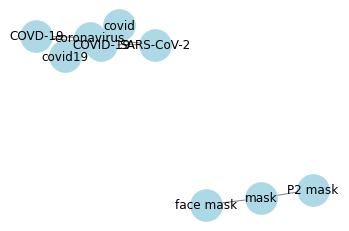

In [ ]:
# KB knowledge_graph
# It is clear to see the associated names for cannonical name
KB.knowledge_graph()

##### 2.3.2 Auto create KB

In [ ]:
# build KB2 using the first 20 articles
KB2 = KnowledgeBase(data_v2_clean[:30])

# Avoid repeated
KB2.kb = {} 

# Auto build kb
KB2.auto_build_kb()

In [ ]:
# Visulization of patial of auto kb
# Relationships are not described correctly and the objects are not expected
print(KB2.kb['COVID-19'])

[{'relation': 'conform typical clinical positive nasopharyngeal oropharyngeal', 'object': 'presentation swab'}, {'relation': 'high physical correlate impair physical mental', 'object': 'comparison SF-36'}, {'relation': 'ass prior conclude natural', 'object': 'history'}, {'relation': 'report new', 'object': 'March countries coronavirus WHO'}, {'relation': 'potential severe propose', 'object': '21'}, {'relation': 'common include dry', 'object': 'fever'}, {'relation': 'coronary thrombotic vaccinate', 'object': 'India'}, {'relation': 'disease affect various', 'object': 'way world'}, {'relation': 'pandemic cause potential economic', 'object': 'infection'}, {'relation': 'depend', 'object': 'recipients'}, {'relation': 'rise cite mental natural', 'object': 'awareness life address reflection death deaths'}]


In [ ]:
# test auto_build_kb accuracy
KB2.search("COVID-19")

['presentation swab',
 'comparison SF-36',
 'history',
 'March countries coronavirus WHO',
 '21',
 'fever',
 'India',
 'way world',
 'infection',
 'recipients',
 'awareness life address reflection death deaths']

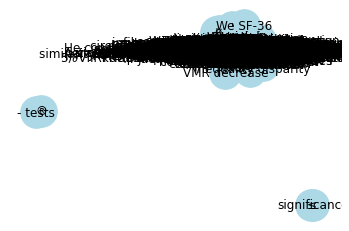

In [ ]:
# KB knowledge_graph
# It is hard to see the associated names for cannonical name
KB2.knowledge_graph()

### 3. Indexing method

#### 3.1 summary
Our **InvertedIndex** function use Named Entity as index.

First, it will perfrom a quick search for all the Named Entity based on NER dictionary / entities (in Section 2.2). If we found the query Named Entity in entities, docs_index list will add the related docid according to entities dictionary.

Then, if it cannot be found in entities dictionary, we will perform a greedy search based on the content of all the articles. If we found the query Named Entity exsiting in a article, docs_index list will add the related docid. This is used to handle some special cases, such as "coronavirus".

Finally, we return a docs_index list.

P.S. Code in Section 3.2 Inverted indexing method

#### 3.2 Inverted indexing method

In [116]:
def InvertedIndex(query, ent_dic, data):
    """
    Retrieve a set of documents containing the given query term
    Input:
    query -> one word representing the query term
    ent_dic -> control the range of entities
    data -> control the size of data
    output:
    doc_index -> list of document IDs
    """
    # empty dictionary to store a set of documents
    docs_index = []

    # Retrieve the set of documents containing each query term
    # k: docid; v: name entities and labels
    for k, v in ent_dic.items():
        for i in v[0]['text'].split():
           if query == i:
              # if doc_id not in docs_index list
              if k not in docs_index:
                  docs_index.append(k)

    # In case cannot find the named_entities, use query to match text
    for i in range(data.shape[0]):
       if query in data['clean'][i]:
          id = data['docid'][i]
          if id not in docs_index:
            docs_index.append(id)

    return docs_index

In [ ]:
# Create an inverted index
# Search for documents containing "COVID-19"
result = InvertedIndex("COVID-19", entities_30, data_v2_clean[:30])
print('Search for documents containing "COVID-19", result:\n', result)

Search for documents containing "COVID-19", result:
 ['qk0cyee2', 'ymebxodh', 'g0bgp3t7', 'm5pwtv7d', 'whchytrr', 'yi870wr8', 'lswvw426', 'l9vye5ci', 'hm0ovsq4', 'ltgadsp7', '0n0vbax3', '0o4zxngp', 'c2ibxbgo', '10409mar', 'okihfpp6', 'xtu9r72l', 'jfca5rv6', '9k1fb5bs', 'h4hxvov8', 'dtyrjfo5', 'daix3d5e', 'yajnzgd5', 'gcc1qjej', 'r9c4odva']


### 4. Text matching utility

#### 4.1 Summary
Our **text_matching_utility class**  retrieves articles based on a question (in Section 4.2). 

Our main function is **text_matching** function (in Section 4.2). Process:

1.   First, we pre-process the question by removing stopwords and lemmization by **query_preprocessing** function.
2.   After we identify named entities in question, we use question named entities by using **get_article_ids** funtion (using **InvertedIndex method** inside function) to find related article ids. Use **KB** to provide a supplement (giving associated name) to named entities in query and get article ids by **get_article_ids** funtion again. 
3. If no article ids, print ""Sorry, no answer for this question." and return. 
4. If we get article ids, we use **get_topk_answers** function to get top k article id, top k answers (first using similarity score to compare question and possible articles, then calculate similarity score between question and each sentence in one article and get best sentence), and cosine similarity score (compare question and best sentence).

NER and KB is useful for my task:

*   Combination of NER and Inverted Index method helps to find article ids efficiently. We only compare question and those articles including named entities rather than all articles. 
*   Using KB as a supplement to find associated named entities for query will help to increase the accuracy of retrieval. Also, 'relation' of named entities will help to find the best answer (this will be explored in the future). 

Pretrained Word Vectors model:

*   At the Begining, we considered Word2Vec and GloVe. After research, we found that GloVe may be better suited for tasks that require a more holistic understanding of language and the relationships between words, which will help us to find a better answer [5][6]. And Word2Vec may be better suited for tasks that require more precise word-level associations. We decide to use GolVe but it's embedding dictionary does not include word such as "COVID-19". (in section 4.5.1)
*   Therefore, we tried tf-idf (in section 4.3) and spaCy pretrain word vector model (in section 4.4). Result discussion in section 4.5.





  

#### 4.2 Text matching utility class

In [166]:
sting = "a b"
sting.split(" ")

['a', 'b']

In [209]:
from nltk.sem.logic import read_type
# https://spacy.io/models/en#en_vectors_web_lg
class text_matching_utility():
    def __init__(self, entities, dataset, kb):
        self.ner = entities              # named entity recognition result
        self.data = dataset              # dataset
        self.kb = kb                     # Knowledge Base

    def query_preprocessing(self, query):
        # regular expression to match text patterns
        s = " \[(?=.*\d).*?\]" 

        # Removing stopwords + Lemmalization
        # Stop words are common words that are typically removed from text data before analysis.
        # Lemmatization is the process of reducing a word to its base form, known as its lemma. 
        stop_words = stopwords.words('english')
        stop_words.extend(["This", "The", "the"])
        lemmatizer = WordNetLemmatizer()
        result = [" ".join([lemmatizer.lemmatize(word) for word in re.sub(s, "", query).split() if word not in stop_words])]
        return result
    
    def get_article_ids(self, query):
        """
        Use inverted index method.
        query-> list of words
        output -> article_ids
        """
        index_dic = []
        if len(query) == 1:
            docs_index = InvertedIndex("".join(query), self.ner, self.data) 
            index_dic.extend(docs_index)
        else:
            for i in query:
              # use inverted index method
              docs_index =  InvertedIndex(i, self.ner, self.data) 
              index_dic.extend(docs_index)
        # avoid repeated doc_id
        index_dic = list(set(index_dic))

        return index_dic

    def tf_idf_score(self, query, articles):
        """
        Use TfidfVectorizer() to convert the text into a matrix of TF-IDF features.
        Return tf-idf similarity score.
        """          
        vectorizer = TfidfVectorizer()
        # convert to word vector
        articles_wv = vectorizer.fit_transform(articles)
        # convert to word vector
        query_wv = vectorizer.transform(query)
        # calculate similarity
        similarities = cosine_similarity(query_wv, articles_wv)[0]
        return similarities

    def spacy_score(self,query, articles):
        """
        Use Spacy to convert text into word vectors.
        Return Spacy similarity score.
        """
        # convert to word vector
        query_nlp = nlp_md(str(query))
        # convert to word vector
        articles_nlp = [nlp_md(article) for article in articles]
        # calculate similarity
        similarities = [query_nlp.similarity(article_nlp) for article_nlp in articles_nlp]
        return similarities
    
    def get_best_sentence(self, query, article, article_id, word_vector):
        """
        Get the best sentence in one article for a query. 
        Based on cosine similarity score between query and sentences.
        """
        # convert to text into sentences
        sentences_clean = tokenize.sent_tokenize(article)

        # calculate similarity
         # Step 3: select different method according to word_vector
        # Then, get cosine similarity between question and articles
        if word_vector == "tf-idf":
           similarities = self.tf_idf_score(query, sentences_clean)
        if word_vector == "spaCy":
           similarities = self.spacy_score(query, sentences_clean)

        # get the maximum score index position
        best_idx = np.array(similarities).argmax()
        # get the best score
        best_score = max(similarities)
        # get original data
        for j in range(len(self.data['docid'])):
              if self.data['docid'][j] == article_id:
                  body = self.data['body'][j]
        sentences_body = tokenize.sent_tokenize(body)
        answer = sentences_body[best_idx]
        return answer,best_score
        

    def get_topk_answers(self, query, article_ids, k, word_vector):
        # print(word_vector)
        """
        Calculate similarity score of matching with the question.
        Get the answer from articles.
        Return top k result based on similarity score
        """
        # Step 1: creat a  empty DataFrame  
        answer_score_df = pd.DataFrame()
        # store article ids
        answer_score_df['Docid'] = article_ids       

        # Step 2: get articles based on ids
        articles = []
        answers = []
        for i in article_ids:
            for j in range(len(self.data['docid'])):
              if self.data['docid'][j] == i:
                articles.append(self.data['clean'][j])
        answer_score_df['Articles'] = articles
        # answer_score_df['Answer'] = answers

        # Step 3: select different method according to word_vector
        # Then, get cosine similarity between question and articles
        if word_vector == "tf-idf":
           similarities = self.tf_idf_score(query, articles)
        if word_vector == "spaCy":
           similarities = self.spacy_score(query, articles)
        # store similarity socre
        answer_score_df['Article_Score'] = similarities

        # Step 4: sort the articles by their similarity scores and get the top results
        answer_score_df2 = answer_score_df.sort_values(by='Article_Score', ascending=False)[:k]

        # Step 5: select the best answer sentence in the top k articles
        answer_list = []
        scores = []
        cnt = 0
        for index, row in answer_score_df2.iterrows():  
            article = row['Articles']
            article_id = row['Docid']
            answer, best_score = self.get_best_sentence(query, article, article_id, word_vector)
            answer_list.append(answer)
            scores.append(best_score)
            cnt += 1
            if cnt == k:
              break
        answer_score_df2['Answer'] = answer_list
        answer_score_df2['Score'] = scores

        # Step 6: sort the best answer according to sentence score
        answer_score_final = answer_score_df2.sort_values(by='Score', ascending=False)[:k]

        return answer_score_final
    
    def text_matching(self, question, k=3, word_vector="spaCy"):
        """
        A function for text matching.
        Input:
        question ->  a string of one question
        k -> number of top results, default is 3
        word_vector -> word embedding method, default is "spaCy"
        """

        # Step 1: Question pre-processing
        query = self.query_preprocessing(question)

        # Step 2: Use NER to identify named entities in the question
        # 1) tokenization
        query1 = nlp(" ".join(query)) 

        # 2) get named entities
        query_ents = [ent.text.strip() for ent in nlp(str(query)).ents]

        # Step 3: Use InvertedIndex method and NER to get ariticle IDs
        # 1) if no named entities found in the question using NER
        # article_ids = []
        if query_ents == []:
          article_ids = self.get_article_ids(query)
        if query_ents != []:
          article_ids = self.get_article_ids(query_ents)

        # Step 4: Use KB to find associated name of name entities in the question
        # When articles_ids == [], it means no cannonical name of the entity appear in the articles
        if article_ids == []:
            # convert query list to a string
            query_str = " ".join(query)
            # check query is a single word or not
            if len(query) == 1 and len(query_str.split(" ")) == 1:
                lst = self.kb.search(query_str)  # use KnowledgeBase function
                for i in lst:
                   article_ids.extend(self.get_article_ids(i))
            else:
                for word in query_str.split(" "):
                    lst = self.kb.search(word)  # use KnowledgeBase function
                    for i in lst:
                      article_ids.extend(self.get_article_ids(i)) 

        # Step 5: Check article_ids again
        # If article_ids is empty, finish the function 
        if article_ids == []:
           print("Sorry, no answer for this question.")
           return None

        # remove repeated article_ids
        article_ids = list(set(article_ids))

        # Else: article_ids is not empty, go through step 6
        # Step 6: Get top k articles answer and score   
        top_results = self.get_topk_answers(query, article_ids, k , word_vector)
        
        return top_results

    def display_results(self, top_results): 
        """Funtion to display results only when results is not None."""
        if top_results is not None:       
          print("_"*50+"\n")
          for index, row in top_results.iterrows():
              print("The article id is ", row['Docid'])  
              print("The answer is \n", row['Answer'])
              print("The score is ", row['Score'],"\n")
        return None

#### 4.3 Using tf-idf word vector for text matching

In [210]:
# call the class
matching = text_matching_utility(entities_30, data_v2_clean[:30], KB)

In [211]:
# question for text matching
question = "how to use face mask"
result = matching.text_matching(question, k=3, word_vector="tf-idf")
print("Question: ",question)
matching.display_results(result)

Question:  how to use face mask
__________________________________________________

The article id is  hm0ovsq4
The answer is 
 Vaccination, social distancing, hand hygiene, and face masks are among the common measures to contain the pandemic.5 The clinical manifestation of the disease is often mild and the disease is usually self-limited.
The score is  0.3293123252322099 

The article id is  daix3d5e
The answer is 
 The COVID-19 pandemic led to a sudden suspension of face-to-face teaching activities across the world [1].
The score is  0.3100263144105602 

The article id is  0o4zxngp
The answer is 
 However, on May 1
st
2020, the USFDA has provided Emergency Use Authorization (EUA) and permits the emergency use of the drug for the treatment of suspect and laboratory confirmed COVID 19 case in adult and children hospitalized with severe disease
7
.
The score is  0.29254385101575964 



In [212]:
# question for text matching
question = "what is COVID-19"
result = matching.text_matching(question, k=3,word_vector="tf-idf")
print("Question: ",question)
matching.display_results(result)             

Question:  what is COVID-19
__________________________________________________

The article id is  yi870wr8
The answer is 
 The only way to distinguish whether COVID-19 is responsible for these symptoms is to compare patients after COVID-19 with those without.
The score is  0.4625373513413609 

The article id is  10409mar
The answer is 
 The effect of immunosuppression on COVID-19 progression would be dependent on the severity of COVID-19 disease and the phase of graft rejection.
The score is  0.41788885917814034 

The article id is  c2ibxbgo
The answer is 
 The COVID-19 pandemic itself can cause fears of COVID-19 infection, uncertainty, and potential economic problems (Sher, 2020).
The score is  0.3989935198869362 



In [213]:
# question for text matching
question = "What are the names of coronavirus variants"
result = matching.text_matching(question, k=3,word_vector="tf-idf")
print("Question: ",question)
matching.display_results(result)   

Question:  What are the names of coronavirus variants
__________________________________________________

The article id is  0n0vbax3
The answer is 
 Vaccine related thrombo-embolic (TE) complications, though rare, have been reported with COVID-19 vaccines, mainly from Europe and North America.
The score is  0.599550586746604 

The article id is  yajnzgd5
The answer is 
 What is the perception of the people stopped by police?
The score is  0.5746394795996549 

The article id is  jfca5rv6
The answer is 
 What would these entail?
The score is  0.5325804308709707 



#### 4.4 Using spaCy pretrained word vector for text matching

In [214]:
# call the class
matching = text_matching_utility(entities_30, data_v2_clean[:30], KB)

In [215]:
# question for text matching
question = "how to use face mask"
result = matching.text_matching(question, k=3, word_vector="spaCy")
print("Question: ",question)
matching.display_results(result)

Question:  how to use face mask
__________________________________________________

The article id is  m5pwtv7d
The answer is 
 The article begins with [Investors’ View] toward Arabic online content to introduce the issue.
The score is  0.6183195148989343 

The article id is  ztzsj45b
The answer is 
 The noncanonical face of CLEC-2 is commonly used in both interactions.
The score is  0.35853787634440476 

The article id is  yajnzgd5
The answer is 
 Unconscious bias and racism is also present in policing and should be addressed.
The score is  0.31002969680626086 



In [216]:
# question for text matching
question = "what is COVID-19"
result = matching.text_matching(question, k=3,word_vector="spaCy")
print("Question: ",question)
matching.display_results(result)             

Question:  what is COVID-19
__________________________________________________

The article id is  m5pwtv7d
The answer is 
 The introduction presents Taghreedat and what it has achieved in the previous two years, and then the subheadings [Production Culture] and [Huge Gap] are used to construct the narrative.
The score is  0.6021586605743622 

The article id is  g0bgp3t7
The answer is 
 This temporal coordination was notably absent in SARS-CoV-2 infected RMs (Figures 4C, D).
The score is  0.2123079015633469 

The article id is  r9c4odva
The answer is 
 The radiologists’ reported findings for patients diagnosed with appendicitis were tabulated and compared between the two groups.
The score is  0.19024892673230334 



In [224]:
# question for text matching
question = "What are the names of coronavirus variants"
result = matching.text_matching(question, k=3,word_vector="spaCy")
print("Question: ",question)
matching.display_results(result)   

Question:  What are the names of coronavirus variants
__________________________________________________

The article id is  m5pwtv7d
The answer is 
 The introduction presents Taghreedat and what it has achieved in the previous two years, and then the subheadings [Production Culture] and [Huge Gap] are used to construct the narrative.
The score is  0.6262686848022553 

The article id is  ztzsj45b
The answer is 
 These results provide a novel strategy for MPM diagnosis and could offer useful information for treating and predicting MPM patients’ prognoses.
The score is  0.2743552448454859 

The article id is  2sptdcbj
The answer is 
 The authors have no conflicts of interest or funding relevant to this commentary.
The score is  0.24120648562252142 



#### 4.5 Result Discussion
Here, we discuss about pretrained word vector model selection and testing results.

In this part, we can see that GloVe is not maintained, and it is hard to find words like "COVID-19" and "covid" (see below code). And it takes too much time to train our own corpus. That's why, we tried tf-idf and spaCy pretrained Word Vector model.

Our questions are

1.   how to use face mask
2.   what is COVID-19
3.   What are the names of cornavirus variants

Table: Score comparision

| Question ID |    tf-idf   |     spaCy   |
| ----------- | ----------- | ----------- |
|      1      |    0.329    |   0.618     |
|      2      |    0.462    |   0.602     |
|      3      |    0.60     |   0.626     |

From table, we can see spaCy got higher scores than tf-idf for all three questions when we compare top 1 answer score. However, answer from spaCy is not related to our query. 


For question 1 about face mask, our tf-idf answer is "Vaccination, social distancing, hand hygiene, and face masks are among the common measures to contain the pandemic.5 The clinical manifestation of the disease is often mild and the disease is usually self-limited." (top1 answer) However, spaCy answers " I knew I could help and make a difference but was unable to." Although spaCy had higher score, it's answer is incorrect and irrelevant. At least tf-idf is good at matching the key word "face mask" of our query with text and find a answer related to our query. For the second and last questions, both of them are not answer correctly. In total, tf-idf tried to match text as much as possible.

Therefore, we can conclude that tf-idf has better performance than spaCy. It helps to identify the most important words in a document. It reduces the impact of common words, such as "the", "and", and "a" appear frequently in most documents. By computing the TF-IDF scores for different documents, it is possible to compare them and identify similarities and differences.

spaCy uses pre-trained word embeddings that are trained on large, diverse datasets, which results in high-quality embeddings. But actually, it does not work well in text matching in our experiment. 

A possible reason why TF-IDF may be more effective is that it is based on the frequency of words in a document or corpus, whereas spaCy word embeddings capture more complex semantic relationships between words. After preprocessing query, only some keywords are left and it may hard for Sapcy to work.

In [ ]:
# loading the 100-dimensional GloVe embeddings
embedding_dict = {}
with open('/content/drive/My Drive/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector
print(embedding_dict.get('COVID-19'))
print(embedding_dict.get('covid'))

None
None


### 5. Test utility and test results

#### 5.1 Summary
MRR stands for Mean Reciprocal Rank, and it is a measure used to evaluate the effectiveness of a search engine algorithm. IMRR measures the average rank of the first relevant result in a set of search results, where each rank is weighted by its reciprocal value. 

The formula for MRR is as follows (shown in **gett_mrr_rank** and **calculate_mrr** function):
MRR = (1/N) * sum(1/rank) [3]

Our MRR result is only 0.158, which means that our search engine algorithm is not effective. As MRR takes into account not only whether a result is relevant or not, but also the order in which the results are presented.

A possible reason is it is hard to match the question patten to a best sentence in the article. And it is hard to analyze semantics according to relationship such as "How many", "when", "what" and "which". If we can use update our KB with more "relation", it may imporve MRR result.  

In [221]:
class test_utility(text_matching_utility):
    def __init__(self, entities, dataset, kb):
      super().__init__(entities, dataset, kb)
    
    # Function to get the reciprocal rank
    def get_mrr_rank(self, answers, correct_answer):
      for i, answer in enumerate(answers):
              if answer is None:
                  answer = ""
              if correct_answer in answer:
                  return 1 / (i + 1), correct_answer
      return 0, None

    # Function to get query answer
    def get_query_answer(self, question, k, word_vector):
        answers = []
        top_results = self.text_matching(question, k, word_vector)
        if top_results is None:
            answers.append("None")
        else:
          for index, row in top_results.iterrows():
              answers.append(row['Answer'])  
        return answers

    # Function to calculate MRR
    def calculate_mrr(self, test_questions, answers):        
        rr_sum = 0
        results_answers = []
        for i in range(1,11):
            correct_answer = test_questions[i]['answer']
            result_mrr = self.get_mrr_rank(answers, correct_answer)
            rr_sum += result_mrr[0]
            results_answers.append(result_mrr[1])
        
        return rr_sum / len(test_questions), results_answers

    def main(self ,test_questions, k=30, word_vector='tf-idf'):
      answers = []
      for i in range(1,11):
          answers = self.get_query_answer(test_questions[i]['query'], k=30, word_vector='tf-idf') #k=30 means the total articles is 30
      mrr_result = self.calculate_mrr(test_questions, answers)
      print("MRR result is \n", mrr_result[0])
      print("Answers: \n", answers)

In [219]:
test_questions = {
   1: {"query":"how many death worldwide because of COVD-19", "answer":"4 million"}, # "article_id":data_v2_clean['docid'][1], 
   2: {"query":"when did Wuhan reported COVID-19", "answer":"31 December 2019"}, # "article_id":data_v2_clean['docid'][7]
   3: {"query":"In 1936, how many cases André Lemierre published", "answer":"20"}, # "article_id":data_v2_clean['docid'][9]
   4: {"query":"which city initially reported COVID-19", "answer":"Wuhan"}, # "article_id":data_v2_clean['docid'][7]
   5: {"query":"what Iran ranks in the world in deaths due to COVID-19",  "answer":"eigth"}, #"article_id":data_v2_clean['docid'][10]
   6: {"query":"Nightingale Hospitals in UK", "answer":"constructed"}, # "article_id":data_v2_clean['docid'][16]
   7: {"query":"when is the first COVID-19 patient in Japan was diagnosed",  "answer":"January 2020"}, # "article_id":data_v2_clean['docid'][17],
   8: {"query":"what is Tuberculosis", "answer":"disease"}, # "article_id":data_v2_clean['docid'][19], 
   9: {"query":"when did the World Health Organization classified COVID-19 as a pandemic", "answer":"2020"}, # "article_id":data_v2_clean['docid'][25]
   10:{"query":"On 11 March 2020, how many countries reported cases of COVID-19", "answer":"114"}, # "article_id":data_v2_clean['docid'][7]
}

In [222]:
# call the class
test = test_utility(entities_30, data_v2_clean[:30], KB)
# get mrr
test.main(test_questions)

Sorry, no answer for this question.
MRR result is 
 0.15833333333333335
Answers: 
 ['A schematic diagram of the mechanism involved in the protective effect of exosomes against hepatic I/R injury is presented in Fig.', 'On 11 March 2020, with cases of COVID-19 reported in 114 countries, the World Health Organization (WHO) declared the outbreak of this new coronavirus a pandemic (WHO 2020).', 'On March 11, 2020, after the overwhelming global expansion of SARS-CoV-2, the World Health Organization classified COVID-19 as a pandemic.2 The number of confirmed COVID-19 cases on December 12, 2020, was approximately 71 797 890 patients with a death toll up to 1 607 590 in over about 216 countries.3 It is a pity that SARS-CoV-2 is highly infectious and might develop some fatal consequences.', 'The results from the assessors were validated by internal agreement on the rating of the intensity of one of the attributes, as described by Montero et al.', 'At the beginning of March 2020, the methodology

### 6. Simple user interface

#### 6.1 Summary
Our user interface outputs three top ranked answers: article number, snippets of text that answers the question and the confidence of the answer.

We had asked two questions in our QA_interface:

1.   which city initially reported COVID-19
2.   what Iran ranks in the world in deaths due to COVID-19

For the first question, our correct answer ranks first, with confidence score of 0.425.

For the second question, our correct answer ranks first, with confidence score of 0.592.

Although our confidence score is not high, we can find out the correct answer in top 3 ranked answers, which means the performance of our search engine is acceptable.

The possible reason is our query parttens match well with the correct answer sentence using tf-idf. 

In [ ]:
class QA_interface(text_matching_utility):
    def __init__(self, entities, dataset, kb):
      super().__init__(entities, dataset, kb)

    def main(self):
        question = None
        print("Please ask a question about COVID.\n")
        print("Please enter 'quit' for quit.\n")
        while True:
          print("Your query is:\n")
          question = str(input())
          if question == 'quit':
              print("\nThank you for your query.")
              break
          top_results = self.text_matching(question, k=3, word_vector="tf-idf")
          plot = self.display_results(top_results)


In [ ]:
user_query = QA_interface(entities_30, data_v2_clean[:30], KB)
user_query.main()

Please ask a question about COVID.

Please enter 'quit' for quit.

Your query is:

which city initially reported COVID-19
__________________________________________________

The article id is  lswvw426
The answer is 
 A novel coronavirus disease 2019 (COVID-19) was initially reported in the city of Wuhan, China, on 31 December 2019 and then began to spread around the world.
The score is  0.4255995860828064 

The article id is  10409mar
The answer is 
 Liver injury has been reported in COVID-19 patients; however, the characteristics in patients with COVID-19-related liver damage remain unknown for liver-transplant recipients [7, 8].
The score is  0.42426643044826784 

The article id is  yi870wr8
The answer is 
 The only way to distinguish whether COVID-19 is responsible for these symptoms is to compare patients after COVID-19 with those without.
The score is  0.32891102785355786 

Your query is:

what Iran ranks in the world in deaths due to COVID-19
____________________________________

### 7. References

[1] https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge

[2] https://www.kaggle.com/code/maksimeren/covid-19-literature-clustering

[3] Jurafsky, D & Martin,JH, 2023, 'Speech and Language Processing', https://web.stanford.edu/~jurafsky/slp3/

[4] https://www.holisticseo.digital/python-seo/information-extraction/

[5] https://www.turing.com/kb/guide-on-word-embeddings-in-nlp#glove:-global-vector-for-word-representation

[6] https://nlp.stanford.edu/pubs/glove.pdf

[7] https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

[8] https://spacy.io/